# Greenhouse time-series model

Walk-forward model that uses external Bet Dagan weather and radiation data as exogenous features to predict internal greenhouse variables (air temp, RH, ET0, internal radiation). Each iteration trains on 1440 rows (10 days at 10 min), tests on 144 rows (1 day), then skips 144 rows (1 day) before the next training window.

In [25]:

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
DATA_DIR = Path('.')
TRAIN_WINDOW = 1440  # 10 days of 10-minute samples
TEST_WINDOW = 144    # 1 day of 10-minute samples
GAP = 0            # no skip between train and test blocks
MAX_TRAIN_ROWS = None  # use full history (no cap)
from xgboost import XGBRegressor






In [26]:
# Load raw files
weather_path = DATA_DIR / "bet_dagan_weather.csv"
radiation_path = DATA_DIR / "bet_dagan_radiation.csv"
micro_path = DATA_DIR / "micro_climate_rh_t_et0.xlsx"

weather = pd.read_csv(weather_path)
radiation = pd.read_csv(radiation_path)
micro = pd.read_excel(micro_path).rename(columns={"internal_rh_%": "internal_rh_pct"})

# Replace Hebrew headers with ASCII names based on column order for reproducibility
weather.columns = [
    "station",
    "timestamp",
    "station_pressure_hpa",
    "rel_humidity_ext",
    "temp_c_ext",
    "temp_max_c_ext",
    "temp_min_c_ext",
    "temp_ground_c_ext",
    "temp_wet_c_ext",
    "wind_dir_deg",
    "gust_dir_deg",
    "wind_speed_ms",
    "wind_speed_max_1m_ms",
    "wind_speed_max_10m_ms",
    "wind_speed_max_10m_time",
    "gust_speed_ms",
    "wind_dir_std_deg",
]

radiation.columns = [
    "rad_station",
    "timestamp",
    "diffuse_rad_wm2",
    "global_rad_wm2",
    "direct_rad_wm2",
]

# Drop station id columns; we only need the measurements
weather = weather.drop(columns=["station"])
radiation = radiation.drop(columns=["rad_station"])

# Convert numeric columns
for df in (weather, radiation, micro):
    for col in df.columns:
        if col not in ("timestamp", "timestamp_dayfirst"):
            df[col] = pd.to_numeric(df[col], errors="coerce")

# Robust parse for micro timestamps (handles mixed formats)
micro_ts_raw = micro["timestamp_dayfirst"].astype(str).str.replace("‏", "", regex=False).str.strip()
micro_ts = micro_ts_raw.apply(lambda x: pd.to_datetime(x, dayfirst=True, errors="coerce"))
unparsed = micro_ts.isna().sum()
if unparsed:
    print(f"Warning: {unparsed} micro rows had unparsable timestamps; dropping them")
micro = micro.assign(timestamp=micro_ts).dropna(subset=["timestamp"])

# Ensure micro is sorted and truncated to the expected campaign window
micro = micro.sort_values("timestamp").reset_index(drop=True)
expected_start = pd.Timestamp("2025-05-29 01:00:00")
micro = micro[micro["timestamp"] >= expected_start].reset_index(drop=True)

# Parse weather/radiation timestamps
weather["timestamp"] = pd.to_datetime(weather["timestamp"], dayfirst=True, format="mixed")
radiation["timestamp"] = pd.to_datetime(radiation["timestamp"], dayfirst=True, format="mixed")

weather = weather.drop(columns=[c for c in weather.columns if weather[c].isna().all()])
radiation = radiation.drop(columns=[c for c in radiation.columns if radiation[c].isna().all()])

# Moisture physics features
def calculate_saturation_vapor_pressure(temp_c):
    return 0.61078 * np.exp((17.27 * temp_c) / (temp_c + 237.3))

def calculate_vpd(temp_c, rh_pct):
    es = calculate_saturation_vapor_pressure(temp_c)
    ea = es * (rh_pct / 100.0)
    return es - ea

def calculate_absolute_humidity(temp_c, rh_pct):
    return (6.112 * np.exp((17.67 * temp_c) / (temp_c + 243.5)) * rh_pct * 2.1674) / (273.15 + temp_c)

weather["vpd_ext"] = calculate_vpd(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["abs_humidity_ext"] = calculate_absolute_humidity(weather["temp_c_ext"], weather["rel_humidity_ext"])
weather["dew_point_ext"] = weather["temp_c_ext"] - ((100 - weather["rel_humidity_ext"]) / 5)

weather.head(), radiation.head(), micro.head()


(            timestamp  station_pressure_hpa  rel_humidity_ext  temp_c_ext  \
 0 2025-05-29 00:00:00                1009.0                70        21.5   
 1 2025-05-29 00:10:00                1008.9                70        21.5   
 2 2025-05-29 00:20:00                1008.8                70        21.5   
 3 2025-05-29 00:30:00                1008.8                71        21.4   
 4 2025-05-29 00:40:00                1008.8                71        21.3   
 
    temp_max_c_ext  temp_min_c_ext  temp_ground_c_ext  wind_dir_deg  \
 0            21.5            21.4               20.8           240   
 1            21.5            21.5               20.8           245   
 2            21.5            21.4               20.5           247   
 3            21.4            21.3               20.4           242   
 4            21.4            21.3               20.3           245   
 
    gust_dir_deg  wind_speed_ms  wind_speed_max_1m_ms  wind_speed_max_10m_ms  \
 0           238      

In [27]:
# Align all sources on timestamp; keep micro as the spine to avoid dropping target rows when weather/radiation are missing
target_cols = ["internal_rh_pct"]
merged = micro.merge(weather, on="timestamp", how="left").merge(radiation, on="timestamp", how="left")
missing_rate = merged.isna().mean() * 100
display(missing_rate.sort_values(ascending=False))
# Reindex to a continuous 10-minute grid using the micro (target) span; fill only exogenous columns
full_range = pd.date_range(micro["timestamp"].min(), micro["timestamp"].max(), freq="10min")
reindexed = merged.set_index("timestamp").reindex(full_range)
reindexed.index.name = "timestamp"
reindexed = reindexed.reset_index()
exogenous_cols = [c for c in reindexed.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst"]]
reindexed = reindexed.set_index("timestamp")
reindexed[exogenous_cols] = reindexed[exogenous_cols].interpolate(method="time").bfill().ffill()
reindexed = reindexed.reset_index()
# Drop rows only if targets are missing
data = reindexed.dropna(subset=target_cols).sort_values("timestamp").reset_index(drop=True)
print(f"Rows after aligning, reindexing, and filling exogenous gaps: {len(data):,}")
print(f"Time span: {data['timestamp'].iloc[0]} -> {data['timestamp'].iloc[-1]}")
# Time-of-day features removed (tod_sin/tod_cos/is_night)

# Optional: manually exclude known-bad windows (fill with tuples of start/end timestamps)
EXCLUDE_WINDOWS = [
    (pd.Timestamp("2025-08-27"), pd.Timestamp("2025-08-30")),
    (pd.Timestamp("2025-09-16"), pd.Timestamp("2025-09-19")),
]  # adjust ranges as needed
if EXCLUDE_WINDOWS:
    before = len(data)
    for start, end in EXCLUDE_WINDOWS:
        data = data[(data["timestamp"] < start) | (data["timestamp"] > end)]
    removed = before - len(data)
    print(f"Removed {removed} rows based on EXCLUDE_WINDOWS")
    data = data.reset_index(drop=True)

# Rolling medians to smooth noisy externals (3-step = 30 minutes)
smooth_cols = [
    "global_rad_wm2",
    "diffuse_rad_wm2",
    "direct_rad_wm2",
    "temp_c_ext",
    "rel_humidity_ext",
]
for c in smooth_cols:
    if c in data.columns:
        data[f"{c}_med3"] = data[c].rolling(window=3, min_periods=1, center=True).median()

# External vapor pressure deficit (VPD) and dew point
if {"temp_c_ext", "rel_humidity_ext"}.issubset(data.columns):
    data["vpd_ext_calc"] = calculate_vpd(data["temp_c_ext"], data["rel_humidity_ext"])
    data["dew_point_ext_calc"] = data["temp_c_ext"] - ((100 - data["rel_humidity_ext"]) / 5)

# Engineered gradients/trends
if "dew_point_ext_calc" in data.columns and "temp_c_ext" in data.columns:
    data["dewpoint_gradient"] = data["dew_point_ext_calc"] - data["temp_c_ext"]
    data["dewpoint_trend_1h"] = data["dew_point_ext_calc"].diff(6)

if "vpd_ext_calc" in data.columns:
    data["vpd_ext_rolling_mean_30min"] = data["vpd_ext_calc"].rolling(window=3, min_periods=1).mean()
    data["vpd_ext_rate_change"] = data["vpd_ext_calc"].diff()
    data["vpd_ext_min_1h"] = data["vpd_ext_calc"].rolling(window=6, min_periods=1).min()

if "global_rad_wm2" in data.columns:
    data["rad_slope_10min"] = data["global_rad_wm2"].diff()
    data["rad_integral_1h"] = data["global_rad_wm2"].rolling(window=6, min_periods=1).sum()
    data["rad_integral_3h"] = data["global_rad_wm2"].rolling(window=18, min_periods=1).sum()
    data["rad_peak_intensity"] = data["global_rad_wm2"].rolling(window=6, min_periods=1).max()

if "temp_c_ext" in data.columns:
    data["temp_ext_diff_10min"] = data["temp_c_ext"].diff()
    data["temp_ext_slope_1h"] = data["temp_c_ext"].diff(6)
    data["temp_ext_range_3h"] = data["temp_c_ext"].rolling(window=18, min_periods=1).apply(lambda x: x.max()-x.min(), raw=False)

if {"temp_c_ext", "dew_point_ext_calc"}.issubset(data.columns):
    data["temp_ext_minus_dewpoint_ext"] = data["temp_c_ext"] - data["dew_point_ext_calc"]

if "rel_humidity_ext" in data.columns:
    data["rh_ext_slope_10min"] = data["rel_humidity_ext"].diff()
    data["rh_ext_slope_30min"] = data["rel_humidity_ext"].diff(3)
    data["rh_ext_range_2h"] = data["rel_humidity_ext"].rolling(window=12, min_periods=1).apply(lambda x: x.max()-x.min(), raw=False)
    data["rh_ext_std_1h"] = data["rel_humidity_ext"].rolling(window=6, min_periods=1).std()

# Drop external ground temp if present
if "temp_ground_c_ext" in data.columns:
    data = data.drop(columns=["temp_ground_c_ext"])

exclude_cols = ["vpd_ext", "abs_humidity_ext", "dew_point_ext", "internal_air_temp_c", "ET0", "internal_radiation"]
feature_cols = [c for c in data.columns if c not in target_cols + ["timestamp", "timestamp_dayfirst"] + exclude_cols]
data.head()









diffuse_rad_wm2          0.929145
ET0                      0.000000
internal_air_temp_c      0.000000
internal_rh_pct          0.000000
internal_radiation       0.000000
timestamp                0.000000
station_pressure_hpa     0.000000
rel_humidity_ext         0.000000
timestamp_dayfirst       0.000000
temp_c_ext               0.000000
temp_max_c_ext           0.000000
temp_ground_c_ext        0.000000
temp_min_c_ext           0.000000
gust_dir_deg             0.000000
wind_speed_ms            0.000000
wind_speed_max_1m_ms     0.000000
wind_dir_deg             0.000000
wind_speed_max_10m_ms    0.000000
gust_speed_ms            0.000000
vpd_ext                  0.000000
wind_dir_std_deg         0.000000
abs_humidity_ext         0.000000
dew_point_ext            0.000000
global_rad_wm2           0.000000
direct_rad_wm2           0.000000
dtype: float64

Rows after aligning, reindexing, and filling exogenous gaps: 16,682
Time span: 2025-05-29 01:00:00 -> 2025-09-21 23:00:00
Removed 866 rows based on EXCLUDE_WINDOWS


,timestamp,timestamp_dayfirst,ET0,internal_air_temp_c,internal_rh_pct,internal_radiation,station_pressure_hpa,rel_humidity_ext,temp_c_ext,temp_max_c_ext,...,rad_integral_3h,rad_peak_intensity,temp_ext_diff_10min,temp_ext_slope_1h,temp_ext_range_3h,temp_ext_minus_dewpoint_ext,rh_ext_slope_10min,rh_ext_slope_30min,rh_ext_range_2h,rh_ext_std_1h
0,2025-05-29 01:00:00,29/05/2025 01:00:00,0.027900,22.775547,74.709380,0.0,1008.8,70.0,21.4,21.4,...,0.0,0.0,NaN,NaN,0.0,6.0,NaN,NaN,0.0,NaN
1,2025-05-29 01:10:00,29/05/2025 01:10:00,0.022799,22.743830,74.193410,0.0,1008.7,70.0,21.3,21.3,...,0.0,0.0,-0.1,NaN,0.1,6.0,0.0,NaN,0.0,0.000000
2,2025-05-29 01:20:00,29/05/2025 01:20:00,0.020941,22.473650,73.349106,0.0,1008.7,70.0,21.2,21.3,...,0.0,0.0,-0.1,NaN,0.2,6.0,0.0,NaN,0.0,0.000000
3,2025-05-29 01:30:00,29/05/2025 01:30:00,0.020224,22.452467,71.715630,0.0,1008.7,68.0,21.1,21.2,...,0.0,0.0,-0.1,NaN,0.3,6.4,-2.0,-2.0,2.0,1.000000
4,2025-05-29 01:40:00,29/05/2025 01:40:00,0.015574,22.511518,71.976640,0.0,1008.8,70.0,21.0,21.2,...,0.0,0.0,-0.1,NaN,0.4,6.0,2.0,0.0,2.0,0.894427


In [28]:
# Define model and expanding walk-forward routine
base_estimator = XGBRegressor(
    n_estimators=1200,
    max_depth=8,
    learning_rate=0.03,
    min_child_weight=6,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    reg_alpha=0.1,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    tree_method='hist',
)

rh_estimator = XGBRegressor(
    n_estimators=1200,
    max_depth=6,
    learning_rate=0.03,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=0.2,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    tree_method='hist',
)

def features_for_target(target):
    if target == "internal_rh_pct":
        return feature_cols + ["internal_air_temp_c", "ET0", "internal_radiation"]
    return feature_cols

def estimator_for_target(target):
    return rh_estimator if target == "internal_rh_pct" else base_estimator

def walk_forward(df, feature_cols, target_cols, model, train_window=TRAIN_WINDOW, test_window=TEST_WINDOW, gap=GAP, max_train_rows=MAX_TRAIN_ROWS):
    """Expanding-window walk-forward: grow train set by each test block."""
    metrics = []
    preds = []
    train_end = train_window
    test_end = train_end + test_window
    run = 0

    while test_end <= len(df):
        train_start_idx = max(0, train_end - max_train_rows) if max_train_rows else 0
        train = df.iloc[train_start_idx:train_end]
        test = df.iloc[train_end:test_end]

        preds_run = {}
        metric = {
            "run": run,
            "train_start": train["timestamp"].iloc[0],
            "train_end": train["timestamp"].iloc[-1],
            "test_start": test["timestamp"].iloc[0],
            "test_end": test["timestamp"].iloc[-1],
            "train_rows": len(train),
            "test_rows": len(test),
        }

        for t_col in target_cols:
            feat_cols_t = features_for_target(t_col)
            model_t = estimator_for_target(t_col)
            model_t = clone(model_t)  # fresh instance
            model_t.fit(train[feat_cols_t], train[t_col])
            pred_t = model_t.predict(test[feat_cols_t])
            preds_run[t_col] = pred_t
            metric[f"mae_{t_col}"] = mean_absolute_error(test[t_col], pred_t)
            metric[f"r2_{t_col}"] = r2_score(test[t_col], pred_t)

        metrics.append(metric)
        preds.append(
            pd.concat(
                [
                    test[["timestamp"] + target_cols].reset_index(drop=True),
                    pd.DataFrame({f"pred_{t}": preds_run[t] for t in target_cols}),
                ],
                axis=1,
            ).assign(run=run)
        )

        print(
            f"Run {run}: train {metric['train_rows']} rows ({metric['train_start']} -> {metric['train_end']}), "
            f"test {metric['test_rows']} rows ({metric['test_start']} -> {metric['test_end']})"
        )
        for t_col in target_cols:
            print(
                f"  {t_col}: MAE={metric[f'mae_{t_col}']:.4f}, R2={metric[f'r2_{t_col}']:.4f}"
            )

        run += 1
        train_end += test_window  # expand training window by one test block (1 day)
        test_end = train_end + test_window

    if not metrics:
        raise ValueError("Not enough data for a single walk-forward run; check window sizes.")

    return pd.DataFrame(metrics), pd.concat(preds, ignore_index=True)






In [29]:
"""
Two-stage approach:
  1) Predict internal_air_temp_c, internal_radiation, ET0 using externals.
  2) Use externals + those predictions to predict internal_rh_pct.
"""

# Stage 1
stage1_targets = ["internal_air_temp_c", "internal_radiation", "ET0"]
metrics_stage1, preds_stage1 = walk_forward(data, feature_cols, stage1_targets, base_estimator, max_train_rows=MAX_TRAIN_ROWS)
display(metrics_stage1)

# Latest predictions per timestamp
pred_latest = (
    preds_stage1.sort_values("timestamp")
    .drop_duplicates(subset=["timestamp"], keep="last")
    [["timestamp"] + [f"pred_{t}" for t in stage1_targets]]
)
data_stage2 = data.merge(pred_latest, on="timestamp", how="left")

# Stage 2: RH using externals + stage1 predictions (no actual internals)
rh_features = [c for c in feature_cols if c not in stage1_targets + ["internal_rh_pct"]] + [f"pred_{t}" for t in stage1_targets]
metrics_rh, preds_rh = walk_forward(data_stage2, rh_features, ["internal_rh_pct"], base_estimator, max_train_rows=MAX_TRAIN_ROWS)
display(metrics_rh)

avg_mae = metrics_rh[[c for c in metrics_rh.columns if c.startswith("mae_")]].mean()
avg_r2 = metrics_rh[[c for c in metrics_rh.columns if c.startswith("r2_")]].mean()
summary = pd.DataFrame([{"variable": "internal_rh_pct", "mae": avg_mae["mae_internal_rh_pct"], "r2": avg_r2["r2_internal_rh_pct"]}])
display(summary)

# Optional saves
# metrics_stage1.to_csv("stage1_metrics.csv", index=False)
# preds_stage1.to_csv("stage1_predictions.csv", index=False)
# metrics_rh.to_csv("rh_metrics_stage2.csv", index=False)
# preds_rh.to_csv("rh_predictions_stage2.csv", index=False)



Run 0: train 1440 rows (2025-05-29 01:00:00 -> 2025-06-08 00:50:00), test 144 rows (2025-06-08 01:00:00 -> 2025-06-09 00:50:00)
  internal_air_temp_c: MAE=0.5429, R2=0.9711
  internal_radiation: MAE=32.3828, R2=0.9241
  ET0: MAE=0.0339, R2=0.9330
Run 1: train 1584 rows (2025-05-29 01:00:00 -> 2025-06-09 00:50:00), test 144 rows (2025-06-09 01:00:00 -> 2025-06-10 00:50:00)
  internal_air_temp_c: MAE=0.4612, R2=0.9713
  internal_radiation: MAE=19.8157, R2=0.9799
  ET0: MAE=0.0300, R2=0.9584
Run 2: train 1728 rows (2025-05-29 01:00:00 -> 2025-06-10 00:50:00), test 144 rows (2025-06-10 01:00:00 -> 2025-06-11 00:50:00)
  internal_air_temp_c: MAE=0.4424, R2=0.9824
  internal_radiation: MAE=21.6960, R2=0.9738
  ET0: MAE=0.0280, R2=0.9650
Run 3: train 1872 rows (2025-05-29 01:00:00 -> 2025-06-11 00:50:00), test 144 rows (2025-06-11 01:00:00 -> 2025-06-12 00:50:00)
  internal_air_temp_c: MAE=0.3670, R2=0.9897
  internal_radiation: MAE=24.4597, R2=0.9545
  ET0: MAE=0.0248, R2=0.9744
Run 4: train

,run,train_start,train_end,test_start,test_end,train_rows,test_rows,mae_internal_air_temp_c,r2_internal_air_temp_c,mae_internal_radiation,r2_internal_radiation,mae_ET0,r2_ET0
0,0,2025-05-29 01:00:00,2025-06-08 00:50:00,2025-06-08 01:00:00,2025-06-09 00:50:00,1440,144,0.542851,0.971077,32.382811,0.924115,0.033902,0.932951
1,1,2025-05-29 01:00:00,2025-06-09 00:50:00,2025-06-09 01:00:00,2025-06-10 00:50:00,1584,144,0.461176,0.971301,19.815739,0.979918,0.029964,0.958357
2,2,2025-05-29 01:00:00,2025-06-10 00:50:00,2025-06-10 01:00:00,2025-06-11 00:50:00,1728,144,0.442447,0.982429,21.695984,0.973752,0.028008,0.965029
3,3,2025-05-29 01:00:00,2025-06-11 00:50:00,2025-06-11 01:00:00,2025-06-12 00:50:00,1872,144,0.367009,0.989663,24.459667,0.954462,0.024789,0.974444
4,4,2025-05-29 01:00:00,2025-06-12 00:50:00,2025-06-12 01:00:00,2025-06-13 00:50:00,2016,144,0.400360,0.982701,36.438637,0.926057,0.028598,0.963115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,94,2025-05-29 01:00:00,2025-09-13 02:50:00,2025-09-13 03:00:00,2025-09-14 02:50:00,14976,144,1.123728,0.921925,19.020093,0.964911,0.020740,0.959033
95,95,2025-05-29 01:00:00,2025-09-14 02:50:00,2025-09-14 03:00:00,2025-09-15 02:50:00,15120,144,0.683561,0.959869,26.629406,0.948481,0.023783,0.946890
96,96,2025-05-29 01:00:00,2025-09-15 02:50:00,2025-09-15 03:00:00,2025-09-19 03:00:00,15264,144,0.970639,0.882031,28.007115,0.945313,0.027304,0.940949
97,97,2025-05-29 01:00:00,2025-09-19 03:00:00,2025-09-19 03:10:00,2025-09-20 03:00:00,15408,144,0.742357,0.931249,34.181793,0.884987,0.031329,0.867533


Run 0: train 1440 rows (2025-05-29 01:00:00 -> 2025-06-08 00:50:00), test 144 rows (2025-06-08 01:00:00 -> 2025-06-09 00:50:00)
  internal_rh_pct: MAE=5.0757, R2=0.5918
Run 1: train 1584 rows (2025-05-29 01:00:00 -> 2025-06-09 00:50:00), test 144 rows (2025-06-09 01:00:00 -> 2025-06-10 00:50:00)
  internal_rh_pct: MAE=1.9534, R2=0.9295
Run 2: train 1728 rows (2025-05-29 01:00:00 -> 2025-06-10 00:50:00), test 144 rows (2025-06-10 01:00:00 -> 2025-06-11 00:50:00)
  internal_rh_pct: MAE=3.2872, R2=0.8620
Run 3: train 1872 rows (2025-05-29 01:00:00 -> 2025-06-11 00:50:00), test 144 rows (2025-06-11 01:00:00 -> 2025-06-12 00:50:00)
  internal_rh_pct: MAE=2.5484, R2=0.8909
Run 4: train 2016 rows (2025-05-29 01:00:00 -> 2025-06-12 00:50:00), test 144 rows (2025-06-12 01:00:00 -> 2025-06-13 00:50:00)
  internal_rh_pct: MAE=2.5084, R2=0.9229
Run 5: train 2160 rows (2025-05-29 01:00:00 -> 2025-06-13 00:50:00), test 144 rows (2025-06-13 01:00:00 -> 2025-06-14 00:50:00)
  internal_rh_pct: MAE=1.92

,run,train_start,train_end,test_start,test_end,train_rows,test_rows,mae_internal_rh_pct,r2_internal_rh_pct
0,0,2025-05-29 01:00:00,2025-06-08 00:50:00,2025-06-08 01:00:00,2025-06-09 00:50:00,1440,144,5.075654,0.591847
1,1,2025-05-29 01:00:00,2025-06-09 00:50:00,2025-06-09 01:00:00,2025-06-10 00:50:00,1584,144,1.953449,0.929466
2,2,2025-05-29 01:00:00,2025-06-10 00:50:00,2025-06-10 01:00:00,2025-06-11 00:50:00,1728,144,3.287184,0.861994
3,3,2025-05-29 01:00:00,2025-06-11 00:50:00,2025-06-11 01:00:00,2025-06-12 00:50:00,1872,144,2.548390,0.890940
4,4,2025-05-29 01:00:00,2025-06-12 00:50:00,2025-06-12 01:00:00,2025-06-13 00:50:00,2016,144,2.508423,0.922860
...,...,...,...,...,...,...,...,...,...
94,94,2025-05-29 01:00:00,2025-09-13 02:50:00,2025-09-13 03:00:00,2025-09-14 02:50:00,14976,144,3.509561,0.845855
95,95,2025-05-29 01:00:00,2025-09-14 02:50:00,2025-09-14 03:00:00,2025-09-15 02:50:00,15120,144,2.866962,0.879472
96,96,2025-05-29 01:00:00,2025-09-15 02:50:00,2025-09-15 03:00:00,2025-09-19 03:00:00,15264,144,2.051602,0.881169
97,97,2025-05-29 01:00:00,2025-09-19 03:00:00,2025-09-19 03:10:00,2025-09-20 03:00:00,15408,144,2.169507,0.869715


,variable,mae,r2
0,internal_rh_pct,2.261288,0.897507


C:\Users\edene\AppData\Local\Temp\ipykernel_21568\243669054.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=sub, palette='viridis')


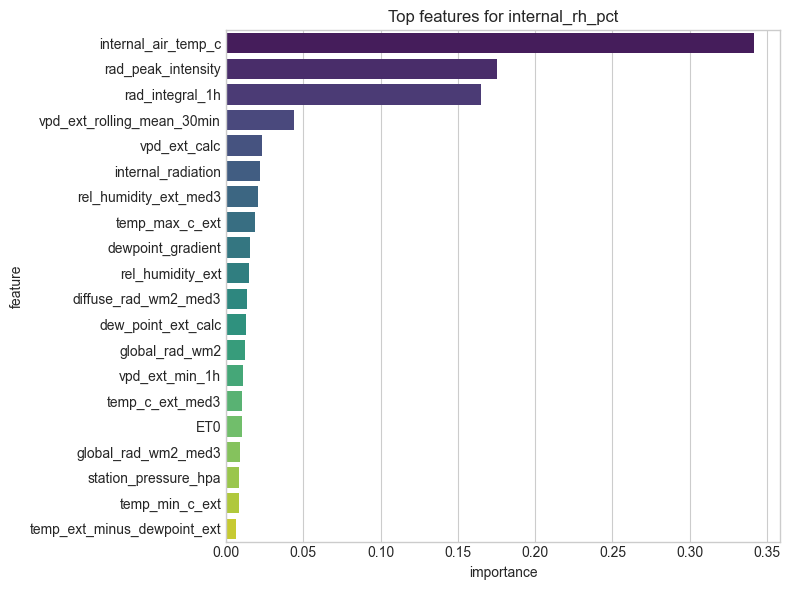

In [30]:

# Feature importance per target (trained once on full dataset)
imp_rows = []
for target in target_cols:
    feat_cols_t = features_for_target(target)
    model_t = clone(base_estimator)
    model_t.fit(data[feat_cols_t], data[target])
    fi = getattr(model_t, 'feature_importances_', None)
    if fi is None:
        print(f'No native feature_importances_ for target {target}; skipping')
        continue
    imp_rows.append(pd.DataFrame({'feature': feat_cols_t, 'importance': fi, 'target': target}))

if len(imp_rows) == 0:
    print('No feature importances available for this model type/version.')
else:
    importance_df = pd.concat(imp_rows, ignore_index=True)
    for target in target_cols:
        sub = importance_df[importance_df['target'] == target].sort_values('importance', ascending=False).head(20)
        plt.figure(figsize=(8, 6))
        sns.barplot(x='importance', y='feature', data=sub, palette='viridis')
        plt.title(f'Top features for {target}')
        plt.tight_layout()
        plt.show()


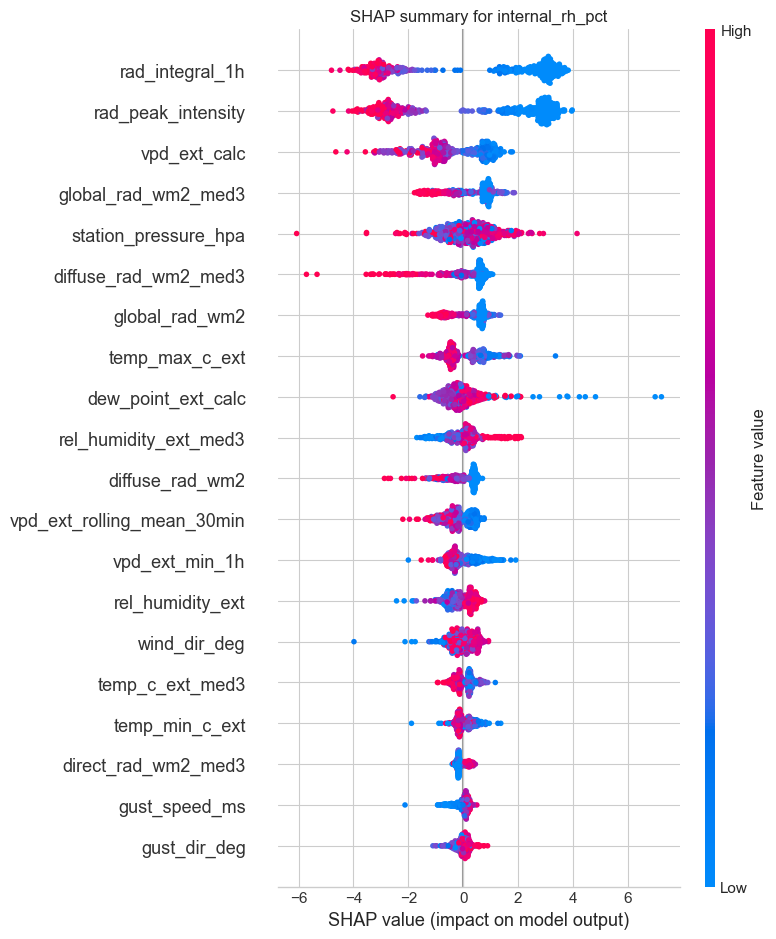

In [31]:
# SHAP explanation for RH on a sample (externals only)
import shap
shap.initjs()

rh_model = clone(rh_estimator)
rh_model.fit(data[feature_cols], data["internal_rh_pct"])

sample_n = min(500, len(data))
shap_sample = data.sample(sample_n, random_state=42)
explainer = shap.TreeExplainer(rh_model)
shap_values = explainer.shap_values(shap_sample[feature_cols])
shap.summary_plot(shap_values, shap_sample[feature_cols], show=False)
plt.title("SHAP summary for internal_rh_pct")
plt.tight_layout()
plt.show()



Found 6 low-R2 runs: [0, 63, 65, 78, 92, 93]


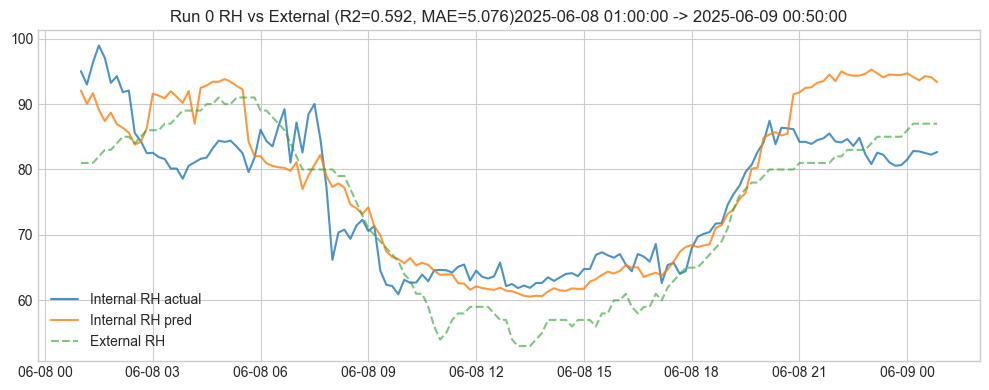

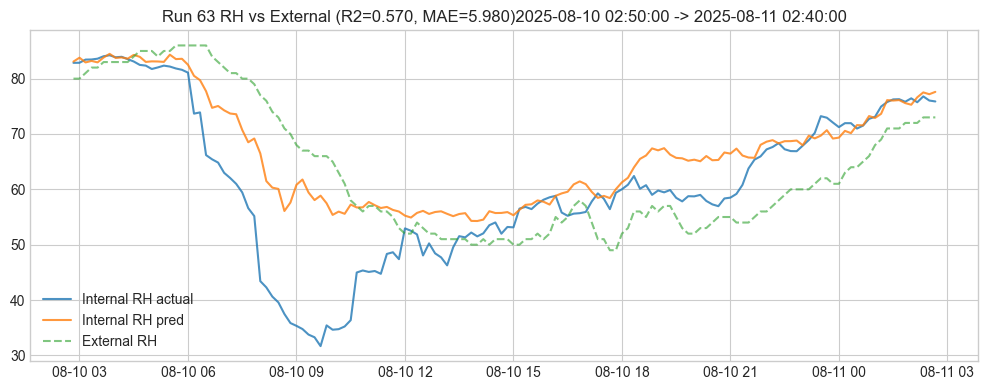

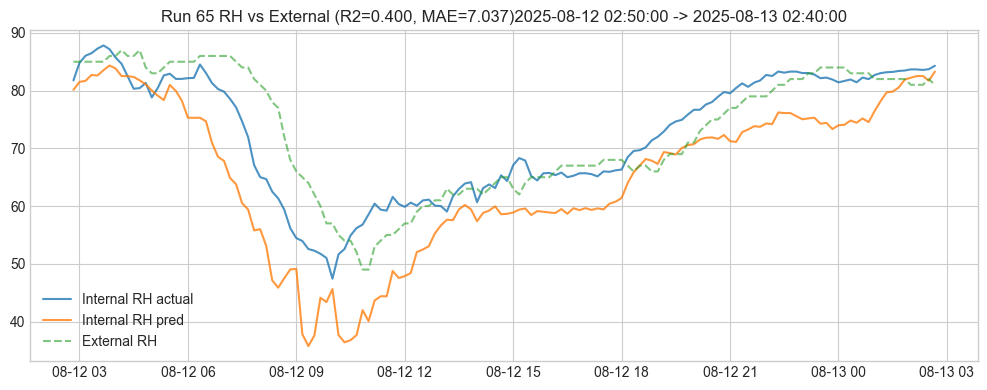

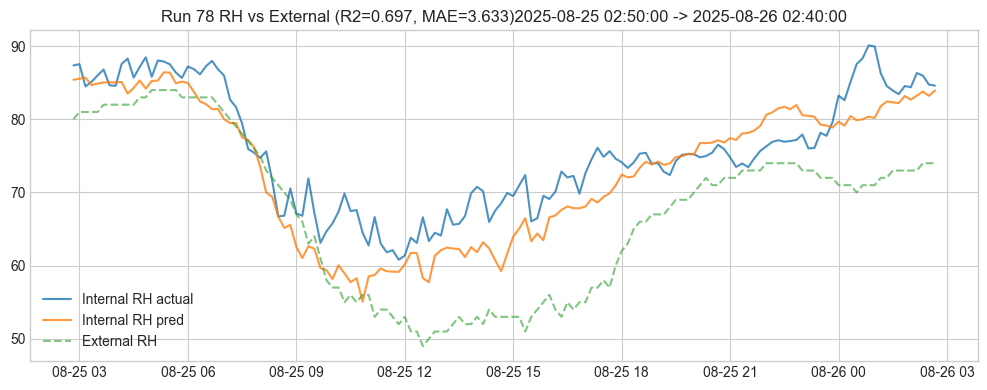

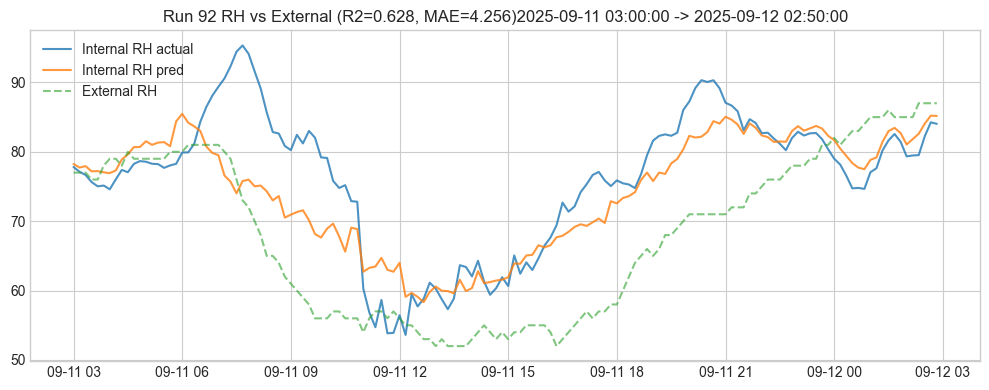

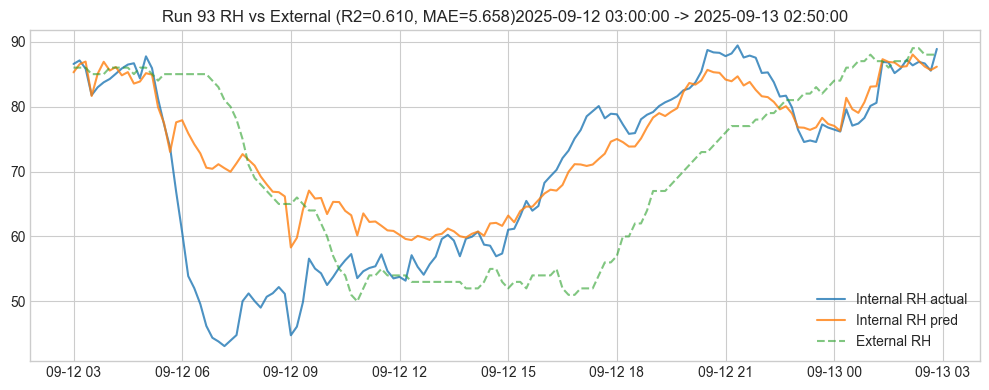

In [32]:
# Plot internal RH vs external RH for runs with low R2 (<0.7)
bad_runs = metrics_df[metrics_df.get("r2_internal_rh_pct", 1) < 0.7]
if bad_runs.empty:
    print("No runs with r2_internal_rh_pct < 0.7")
else:
    print(f"Found {len(bad_runs)} low-R2 runs: {bad_runs['run'].tolist()}")
    for _, row in bad_runs.iterrows():
        r = int(row['run'])
        test_start = row['test_start']
        test_end = row['test_end']
        # actual/pred from preds_df
        sub_pred = preds_df[preds_df['run'] == r]
        # external RH from original data in the test window
        ext_slice = data[(data['timestamp'] >= test_start) & (data['timestamp'] <= test_end)][['timestamp', 'rel_humidity_ext']]
        if sub_pred.empty or ext_slice.empty:
            print(f"Run {r}: missing data; skipping")
            continue
        merged = sub_pred.merge(ext_slice, on='timestamp', how='left')
        plt.figure(figsize=(10, 4))
        plt.plot(merged['timestamp'], merged['internal_rh_pct'], label='Internal RH actual', alpha=0.8)
        if 'pred_internal_rh_pct' in merged.columns:
            plt.plot(merged['timestamp'], merged['pred_internal_rh_pct'], label='Internal RH pred', alpha=0.8)
        plt.plot(merged['timestamp'], merged['rel_humidity_ext'], label='External RH', alpha=0.6, linestyle='--')
        if 'global_rad_wm2' in merged.columns:
            plt.plot(merged['timestamp'], merged['global_rad_wm2'], label='External Global Rad', alpha=0.5, linestyle=':')
        plt.title(f"Run {r} RH vs External (R2={row['r2_internal_rh_pct']:.3f}, MAE={row['mae_internal_rh_pct']:.3f}){test_start} -> {test_end}")
        plt.legend()
        plt.tight_layout()
        plt.show()



